In [1]:
import numpy
import numpy as np
from matplotlib import pyplot as plt
import scipy.linalg
%matplotlib inline

In [2]:
# here is the function to interpolate.
fun = lambda x: np.sin(x*5)

In [3]:
# we want to interpolate
points = numpy.linspace(-0.05, 1.05,100)

# One dimensional interpolation

## Linear Bases

### Chebychev basis.

The chebychev basis is determined by the boundaries, and the number of basis functions we use.

In [196]:
from interpolation.linear_bases.basis_chebychev import ChebychevBasis
cheb_basis = ChebychevBasis(min=0,max=1,n=5)

In [197]:
cheb_basis.n # number of basis functions
cheb_basis.m # number of nodes required to identify the coefficients

5

In [201]:
# the chebychev nodes, that will be used to identify the function:
cheb_basis.nodes

array([ 0.        ,  0.14644661,  0.5       ,  0.85355339,  1.        ])

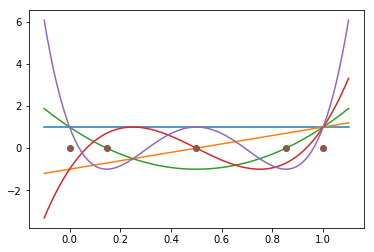

In [202]:
vals = cheb_basis.Phi(points)
for i in range(vals.shape[1]):
    plt.plot(points, vals[:,i])
plt.plot(cheb_basis.nodes, cheb_basis.nodes*0,'o')

#### Interpolate $f$

we will use the values of $f$ at the nodes to construct an interpolation.

In [176]:
v = np.array([fun(p) for p in cheb_basis.nodes])

now we can evaluate all basis matrices at this nodes

In [177]:
B = cheb_basis.B
B.shape

(5, 5)

and get the coefficients:

In [178]:
c = scipy.linalg.solve(B, v)

In [179]:
# remark:
cc = cheb_basis.filter(v)
print(abs(cc-c).max())

0.0


now to interpolate the function

In [180]:
ivals = cheb_basis.Phi(points) @ c

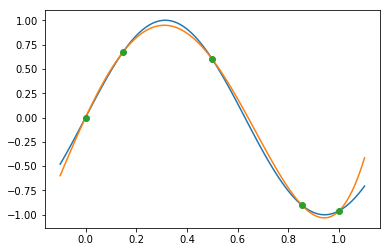

In [181]:
plt.plot(points, [fun(p) for p in points])
plt.plot(points, ivals)
plt.plot(cheb_basis.nodes, [fun(p) for p in cheb_basis.nodes],'o')


### linear interpolation

Now we perform a linear interpolation, using non regularly spaced data

In [182]:
from interpolation.linear_bases.basis_linear import LinearSplineBasis

In [183]:
nodes = numpy.linspace(0,1,5)**2         # the points at which values will be interpolated

In [199]:
linear_basis = LinearSplineBasis(nodes=nodes)

In [200]:
linear_basis.n # number of basis functions

5

In [186]:
linear_basis.nodes     # set of points for which values identify the basis values exactly
print(linear_basis.m)  # number of nodes

5


Now we evaluate all functions of the basis at once on a uniform set of points:

In [203]:
vals = linear_basis.Phi(points)
vals.shape # each column contains the values of one basis function

(100, 5)

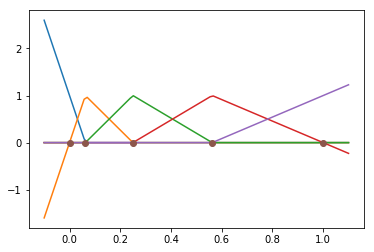

In [204]:
for i in range(vals.shape[1]):
    plt.plot(points, vals[:,i])
plt.plot(linear_basis.nodes, linear_basis.nodes*0,'o')

Interpolation is easier since there is no need to prefilter the coefficients:

In [207]:
v = np.array([fun(p) for p in linear_basis.nodes])

In [210]:
c = v

In [216]:
# remark
print( abs( linear_basis.filter(v) - c) )

[ 0.  0.  0.  0.  0.]


In [211]:
ivals = linear_basis.Phi(points) @ c

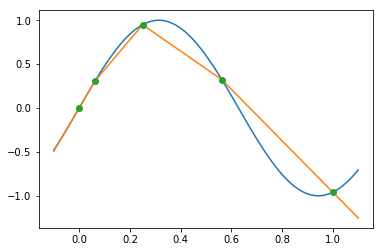

In [212]:
plt.plot(points, [fun(p) for p in points])
plt.plot(points, ivals)
plt.plot(linear_basis.nodes, [fun(p) for p in linear_basis.nodes],'o')

### basis splines (version 1)

First version of basis splines interpolates on non-regular grids at any order.

In [44]:
import interpolation.linear_bases.basis_splines

In [45]:
nodes = numpy.linspace(0,1,5)**2  # the points at which function will be interpolated

number of nodes : 5
number of basis functions: 7
Phi: dense array of size (100, 7)


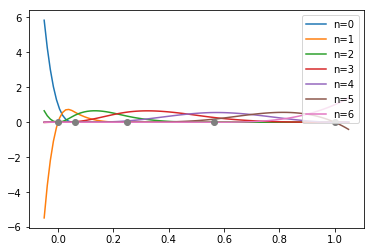

In [46]:
from interpolation.linear_bases.basis_splines import SplineBasis
spline_basis = SplineBasis(nodes)
print("number of nodes : {}".format(spline_basis.n)) # number of nodes
print("number of basis functions: {}".format(spline_basis.m)) # number of basis functions
vals = spline_basis.Phi(points)
print("Phi: dense array of size {}".format(vals.shape))

for i in range(vals.shape[1]):
    plt.plot(points, vals[:,i], label='n={}'.format(i))
plt.legend(loc='upper right')
plt.plot(nodes, nodes*0, 'o')
    

In [47]:
v = np.array([fun(p) for p in spline_basis.nodes])

Now there is something new. There are more functions than available values. The $\Phi$ matrix is not square, hence not invertible.

In [48]:
spline_basis.Phi(spline_basis.nodes).shape

(5, 7)

In [53]:
# Solution 1: (not implemented)
# B = spline_basis.B # a 7x7 matrix, for which the first and the last rows correspond to boundary conditions (for instance f''=0)
# vv = numpy.concatenate([[0], v, [0]]) # or spline_basis.pad(v)
# c = scipy.linalg.solve(B,vv)

In [50]:
# Solution 2: (implemented but totally broken)
c = spline_basis.filter(v)
c.shape

(7,)

In [51]:
ivals = spline_basis.Phi(points) @ c

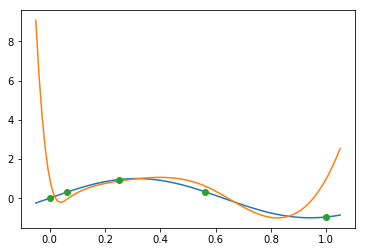

In [52]:
plt.plot(points, [fun(p) for p in points])
plt.plot(points, ivals)
plt.plot(spline_basis.nodes, [fun(p) for p in spline_basis.nodes],'o')

### Uniform Splines

In [6]:
from interpolation.linear_bases.basis_uniform_cubic_splines import UniformSplineBasis
uspline_basis = UniformSplineBasis(0,1,5)
print("number of nodes : {}".format(uspline_basis.n)) # number of nodes
print("number of basis functions: {}".format(uspline_basis.m)) # number of basis functions


number of nodes : 5
number of basis functions: 7


When we evaluate the basis at a set of points, most basis functions are zero. The resulting sparse matrix has a special structure recorded in a CompactBasicMatrix object. Using this object allows for many efficient operations.

In [7]:
vals = uspline_basis.Phi(points)
vals

In [8]:
print(vals.as_matrix().shape) # or vals.shape


(100, 7)


In [9]:
( vals.as_spmatrix() )

<100x7 sparse matrix of type '<class 'numpy.float64'>'
	with 400 stored elements in COOrdinate format>

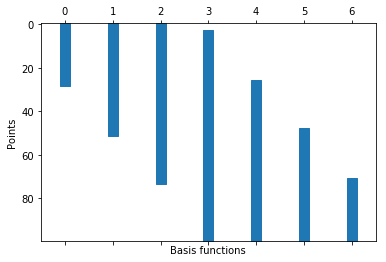

In [10]:
plt.spy(vals.as_spmatrix(), aspect='auto')
plt.ylabel("Points")
plt.xlabel("Basis functions")

Let's interpolate $f$

In [28]:
v = np.array([fun(nn) for nn in uspline_basis.nodes]) # values to interpolate

#### option 1
There are 5 values to interpolate but 7 basis splines to pin down. We thus need to add the boundary conditions:

In [36]:
vv = np.concatenate( [[0], v, [0]] ) # future: vv = uspline_basis.pad(values)

In [39]:
B = uspline_basis.B 
print(B.shape) # this is the square matrix, which identifies the coefficients (include boundary conditions)
%time c = scipy.linalg.solve(B, vv)

(7, 7)
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 584 µs


#### option 2
Since there is an efficient function to filter uniform spline, the following will be more efficient: (note that we don't add boundary conditions)

In [40]:
%time c = uspline_basis.filter(v)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 48.9 µs


In [41]:
# now we can use the coefficients to interpolate at any point:
Phi = uspline_basis.Phi(points)
Phi

In [42]:
interpolated_vals = Phi @ c # this product is made efficiently

In [ ]:
plt.plot(points, [fun(p) for p in points])
plt.plot(points, interpolated_vals)
plt.plot(uspline_basis.nodes, [fun(p) for p in uspline_basis.nodes],'o')

## Interpolating many functions

In [57]:
# here is the function to interpolate.
fun1 = lambda x: np.sin(x*5)
fun2 = lambda x: np.cos(x*5)

In [58]:
from interpolation.linear_bases.basis_chebychev import ChebychevBasis
cheb_basis = ChebychevBasis(min=0,max=1,n=5)

values to be interpolated are given as a matrix. Each column corresponding to a different variable.

In [80]:
v = np.array( [[fun1(p), fun2(p)] for p in cheb_basis.nodes] )
v.shape

(5, 2)

In [67]:
c = cheb_basis.filter(v)
print(c.shape)

(5, 2)


In [71]:
Phi = cheb_basis.Phi(points)
Phi.shape

(100, 5)

In [72]:
x = Phi @ c

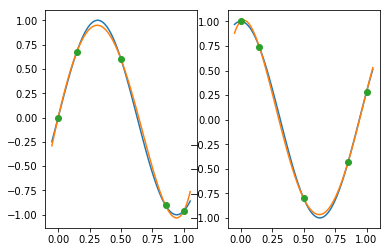

In [79]:

plt.subplot(1,2,1)
plt.plot(points, [fun1(p) for p in points])
plt.plot(points, x[:,0])
plt.plot(cheb_basis.nodes, [fun1(p) for p in cheb_basis.nodes],'o')

plt.subplot(1,2,2)
plt.plot(points, [fun2(p) for p in points])
plt.plot(points, x[:,1])
plt.plot(cheb_basis.nodes, [fun2(p) for p in cheb_basis.nodes],'o')


In [86]:
from interpolation.linear_bases.basis_uniform_cubic_splines import UniformSplineBasis
uspline_basis = UniformSplineBasis(0,1,5)

In [88]:
v = np.array( [[fun1(p), fun2(p)] for p in uspline_basis.nodes] )
v.shape

(5, 2)

In [89]:
c = uspline_basis.filter(v)
print(c.shape)

(7, 2)


In [92]:
Phi = uspline_basis.Phi(points)
print(Phi)
print(Phi.shape)

(100, 7)


In [93]:
x = Phi @ c

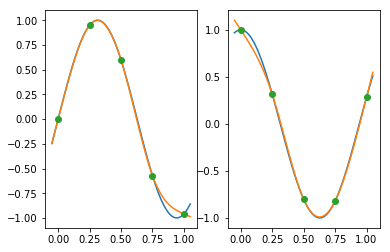

In [95]:
plt.subplot(1,2,1)
plt.plot(points, [fun1(p) for p in points])
plt.plot(points, x[:,0])
plt.plot(cheb_basis.nodes, [fun1(p) for p in cheb_basis.nodes],'o')

plt.subplot(1,2,2)
plt.plot(points, [fun2(p) for p in points])
plt.plot(points, x[:,1])
plt.plot(cheb_basis.nodes, [fun2(p) for p in cheb_basis.nodes],'o')

# Multidimensional interpolation

We try to interpolate the 2d function $f(x,y) = \frac{sin(\sqrt{x^2+y^2})}{\sqrt{x^2+y^2})}$

In [4]:
f = lambda x,y: np.sinc(np.sqrt(x**2 + y**2))
f2 = lambda x,y: np.sinc(np.pow(x**3 + y**3, 1/3))

We have two 1-dimensional bases $\left(b^1_i(x)\right)_i$ and $\left(b^2_j(y)\right)_j$.

The Tensor base is made of the functions: $\left(b^1_i(x) b^2_j(y)\right)_{ij}$

In [5]:
points = [(p,q) for p in np.linspace(-0.05, 1.05,100) for q in np.linspace(-0.05, 1.05,100) ]
points = np.array(points) # points at which we will interpolate
points.shape # each line contains a different set of coordinates

(10000, 2)

## Dense bases

In [32]:
from interpolation.linear_bases.basis_chebychev import ChebychevBasis
cheb_basis_1 = ChebychevBasis(min=0,max=1,n=5)
cheb_basis_2 = ChebychevBasis(min=0,max=1,n=5)

In [33]:
from interpolation.linear_bases.product import TensorBase

In [34]:
tb = TensorBase([cheb_basis_1, cheb_basis_2])
tb

the product base defines 2-dimensional functions. The set of identification nodes is a matrix, which each line is a different point:

(25, 2)


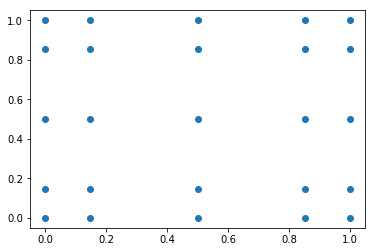

In [35]:
print( tb.grid.shape ) # maybe this should be called nodes
plt.plot(tb.grid[:,0], tb.grid[:,1],'o')

We can evaluate the tensor base at a any list of points:

In [36]:
Phi = tb.Phi(tb.grid)
Phi

In [37]:
Phi.as_matrix().shape

(25, 25)

Compute values to interpolate

In [38]:
nodes = tb.grid
v = [f(nodes[i,0], nodes[i,1]) for i in range(nodes.shape[0])]

We get the coefficient for the tensor product directly:

In [39]:
c = tb.filter(v)
c.shape

(5, 5)

In [40]:
x = tb.Phi(points) * c      # should tb.Phi(points) @ c work ?
x.shape

(10000,)

In [41]:
# equivalent
xx = tb.Phi(points).as_matrix() @ c.ravel()
abs(xx - x).max()

0.0

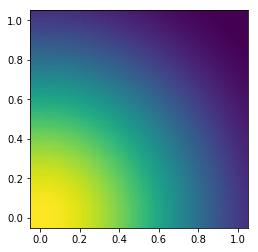

In [42]:
plt.imshow(x.reshape((100,100)), origin='lower', extent=(-0.05,1.05,-0.05, 1.05))


#### multiple functions (not implemented)

In [17]:
v1 = np.array( [f(nodes[i,0], nodes[i,1]) for i in range(nodes.shape[0])] )
v2 = np.array( [f(nodes[i,0], nodes[i,1]) for i in range(nodes.shape[0])] )

In [18]:
v = np.concatenate([v1[:,None],v2[:,None]],axis=1)
v.shape

(25, 2)

In [19]:
tb.filter(v) # this doesn't work yet, but it should

ValueError: solve1: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (m,m),(m)->(m) (size 2 is different from 5)

In [ ]:
coeffs = [tb.filter(v[:,i]) for i in range(v.shape[1])]

## Sparse bases

In [20]:
from interpolation.linear_bases.basis_uniform_cubic_splines import UniformSplineBasis
uspline_basis_1 = UniformSplineBasis(0,1,5)
uspline_basis_2 = UniformSplineBasis(0,1,5)

In [21]:
tb = TensorBase([uspline_basis_1, uspline_basis_2])

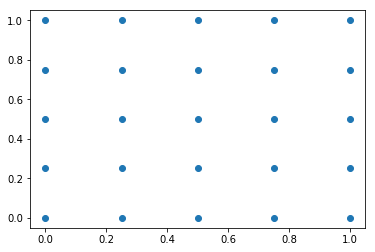

In [22]:
nodes = tb.grid
plt.plot(nodes[:,0], nodes[:,1],'o')

In [23]:
tb.Phi(nodes)

In [24]:
v = np.array( [f(nodes[i,0], nodes[i,1]) for i in range(nodes.shape[0])] )
v = v.reshape([b.n for b in tb.bases])

In [25]:
# we pad manually with boundary conditions
vv = numpy.pad(v,1,'constant')

In [26]:
c = tb.filter(vv[:,:]) # inconsistent API (should take v as argument) 

In [27]:
x = tb.Phi(points) * c

In [28]:
xx = ckp.as_matrix() @ c.ravel()
abs(xx-x).max()

NameError: name 'ckp' is not defined

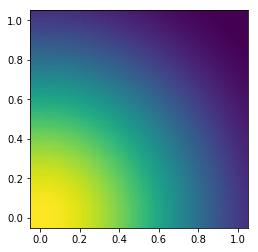

In [29]:
plt.imshow(xx.reshape((100,100)), origin='lower', extent=(-0.05,1.05,-0.05, 1.05))

In [158]:
tb.bases[0].B.shape

(7, 7)

In [159]:
tb.bases[0]

In [163]:
ckb = tb.B(points)

In [165]:
ckb.shape

(10000, 49)